# Patel SMQ2 Analysis
## Xiaonan Wang
## 04May2020

This is a template to analysis SMQ2 experiment using scanpy. Similar to Patel TenX samples, there are 3 conditions:
- WT
- Double KO
- Triple KO

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


# Main analysis
## Read in data and QC

In [2]:
# read in metadata
# This needs to be tidied up first
metadir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/MetaData/'
meta_list = np.array(np.sort(os.listdir(metadir)))
meta_list = meta_list[meta_list!='meta_B2.csv']
print(meta_list)
meta = pd.DataFrame([])
for f in meta_list:
    meta_sub = pd.read_csv(metadir+f,  engine='python')
    meta_sub= meta_sub.dropna(axis=1, how='all')
    meta_sub = smqpp.reformat_meta(meta_sub)
    print(f+':'+str(meta_sub.shape))
    meta = meta.append(meta_sub, ignore_index=True)
    del meta_sub
meta.index=(meta['Sequencing_identifier'].astype(str)+'.'+[x.replace('-', '_') for x in meta['Sequencing_facility_index']]).values
print(meta.shape)

['meta_B1.csv' 'meta_B3.csv' 'meta_B4.csv']
meta_B1.csv:(768, 17)
meta_B3.csv:(768, 17)
meta_B4.csv:(1224, 17)
(2760, 17)


In [3]:
meta['Sequencing_identifier'].value_counts().sort_index()

SLX-14256    384
SLX-14257    384
SLX-14719    384
SLX-14789    384
SLX-16885    288
SLX-16886    288
SLX-16888    288
SLX-16889    288
SLX-16890     72
Name: Sequencing_identifier, dtype: int64

In [3]:
meta.head(1)

Gottgens_ID Sequencing_identifier Plate_number  \
SLX-14719.i701_i502    RBG22838             SLX-14719     Plate_1a   

                    Position_in_96_well_plate_sorted  \
SLX-14719.i701_i502                               A1   

                    Position_in_96_well_plate_RNAseq FACs  \
SLX-14719.i701_i502                               A1  Yes   

                    Unique_sample_descriptor  \
SLX-14719.i701_i502                WT_#1_LSK   

                                                               Details  \
SLX-14719.i701_i502  WT_#1_24927 (Aldh2 KO(+/+); Fancd2 KO (+/+); p...   

                    Cell_type_general Cell_type_subtype               Owner  \
SLX-14719.i701_i502              EryA      CD71+Ter119+  Nicola/Sarah/Patel   

                    Species Sequencing_index Sequencing_facility_index  \
SLX-14719.i701_i502   mouse        N701-S502                 i701-i502   

                     Average_pooled_library_length_bp  Pool_size  \
SLX-14719.i701_i502                             546.0        384   

                     Number_of_lanes  
SLX-14719.i701_i502                2

In [4]:
meta = meta.loc[meta['Sequencing_identifier'] != 'SLX-16890', :]

In [5]:
meta['mouseID'] = [re.search('(\d{5})', x).group(0) for x in meta['Details'].astype(str)]

In [6]:
meta['Condition'] = [re.search('(Aldh2.*\(\S/\S\))', x).group() for x in meta['Details'].astype(str)]

In [7]:
cond_dict = {
    'Aldh2 KO(+/+); Fancd2 KO (+/+); p53 KO (+/+)': 'WT',
    'Aldh2 KO(+/+); Fancd2 KO (+/+); p53 KO (d/d)': 'p53_KO',
    'Aldh2 KO(+/d); Fancd2 KO (+/+); p53 (+/+)': 'WT',
    'Aldh2 KO(+/d); Fancd2 KO (d/d); p53 KO (+/+)': 'Fancd2_KO',
    'Aldh2 KO(d/d); Fancd2 KO (+/+); p53 KO (+/+)': 'Aldh2_KO',
    'Aldh2 KO(d/d); Fancd2 KO (d/d)': 'Aldh2_Fancd2_KO',
    'Aldh2 KO(d/d); Fancd2 KO (d/d); p53 KO (+/+)': 'Aldh2_Fancd2_KO',
    'Aldh2, KO (+/+); Fancd2, KO (+/+); p53, KO (+/+)': 'WT'
}

In [8]:
meta['Cond1'] = [cond_dict[x] for x in meta['Condition']]

In [9]:
Indir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/STAR_results/'
ftable_loc = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis/features.tsv'

In [10]:
folder_list = np.array(os.listdir(Indir))
# remove bulk samples
folder_list = np.sort(folder_list[(folder_list!='SLX14873') & (folder_list!='SLX16890')])
print(folder_list)

['SLX14256' 'SLX14257' 'SLX14719' 'SLX14789' 'SLX16885' 'SLX16886'
 'SLX16888' 'SLX16889']


In [16]:
# define QC thresholds
cutoff_B1 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(150000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_B2 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.1,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.25
          }
cutoff_B3 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(150000),
           'fGenes:nTotal': 0.1,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.28
          }
cutoff_B4 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(150000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_B5 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_B6 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_B7 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }
cutoff_B8 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(120000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.2,
           'nERCC:nMapped': 0.2
          }

In [10]:
# # define QC thresholds
# cutoff_B1=[0, np.log10(150000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
# cutoff_B2=[0, np.log10(120000), 0.1, 0, 0.2, 0.25, float('nan'), float('nan'), float('nan'), float('nan')]
# cutoff_B3=[0, np.log10(150000), 0.1, 0, 0.2, 0.28, float('nan'), float('nan'), float('nan'), float('nan')]
# cutoff_B4=[0, np.log10(150000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
# cutoff_B5=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
# cutoff_B6=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
# cutoff_B7=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
# cutoff_B8=[0, np.log10(120000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]
# #cutoff_B9=[0, np.log10(150000), 0.15, 0, 0.2, 0.2, float('nan'), float('nan'), float('nan'), float('nan')]

In [17]:
cutoff = [cutoff_B1, cutoff_B2, cutoff_B3, cutoff_B4, cutoff_B5, cutoff_B6, cutoff_B7, cutoff_B8]

SLX14256
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 370
Number of failed cells: 14
SLX14257
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 354
Number of failed cells: 30
SLX14719
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Number of passed cells: 346
Number of failed cells: 38
SLX14789
Count table shape: (384, 31053)
Feature table shape:(31053, 7)
mito_genes: ['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 

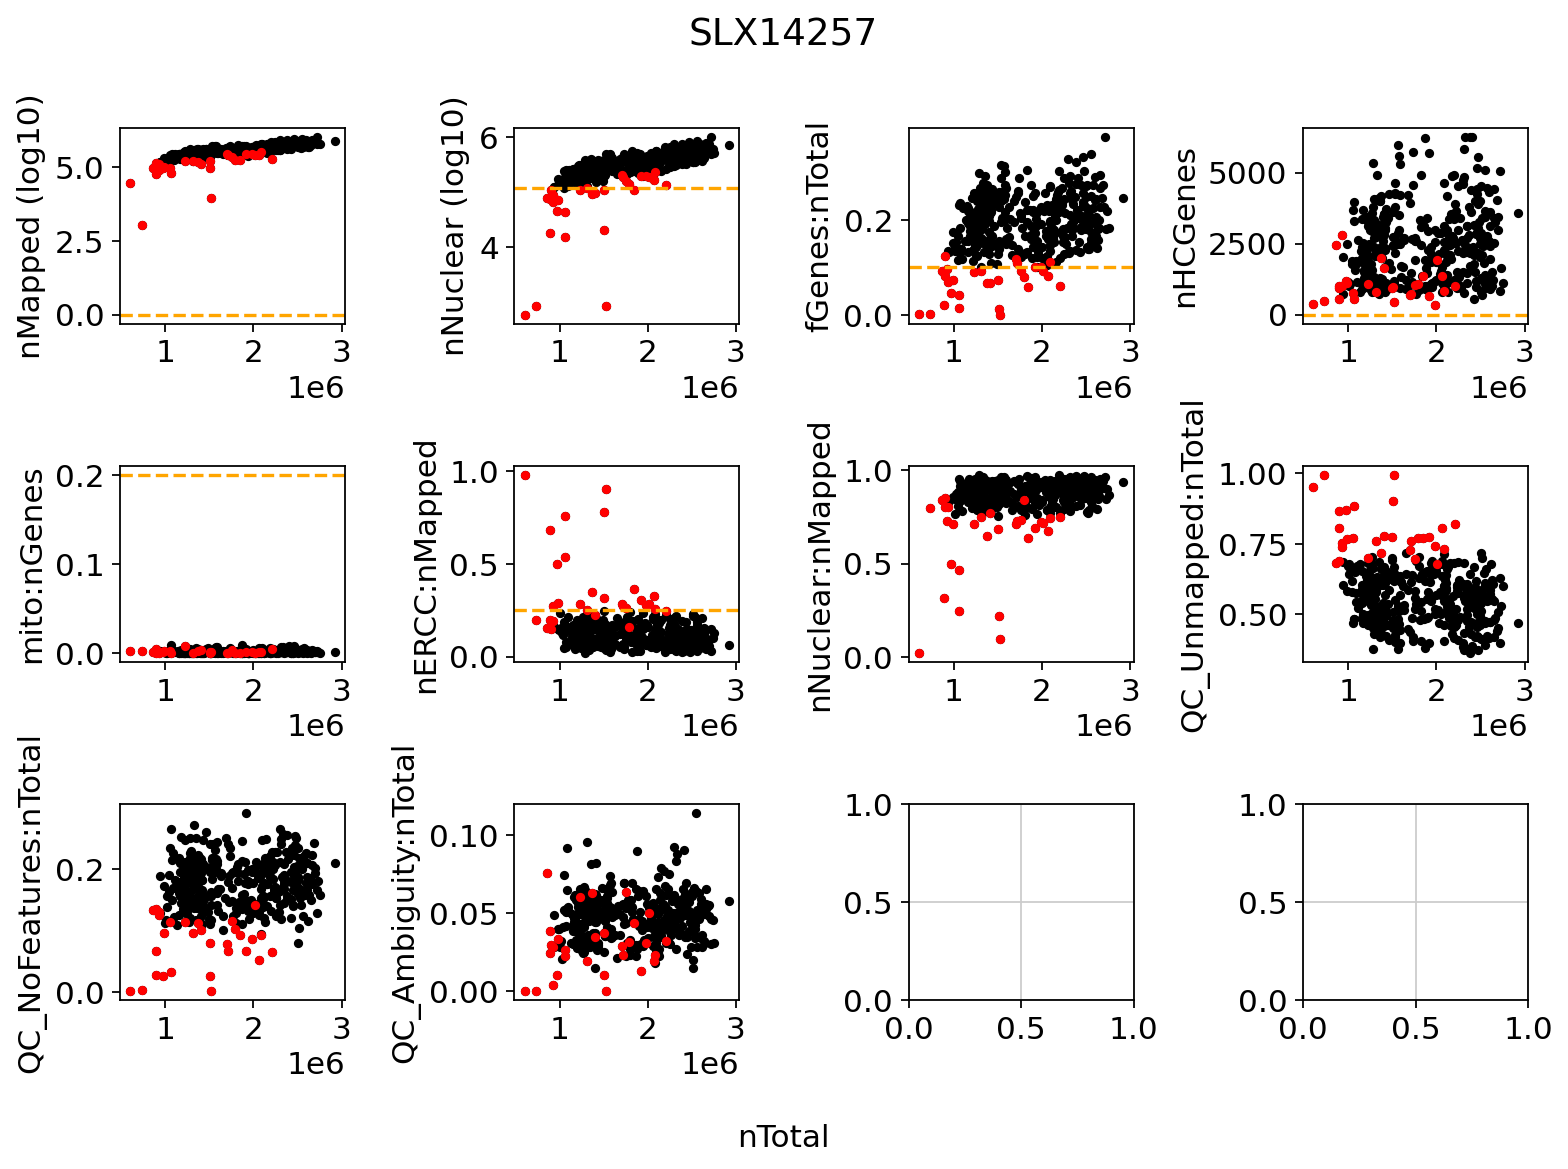

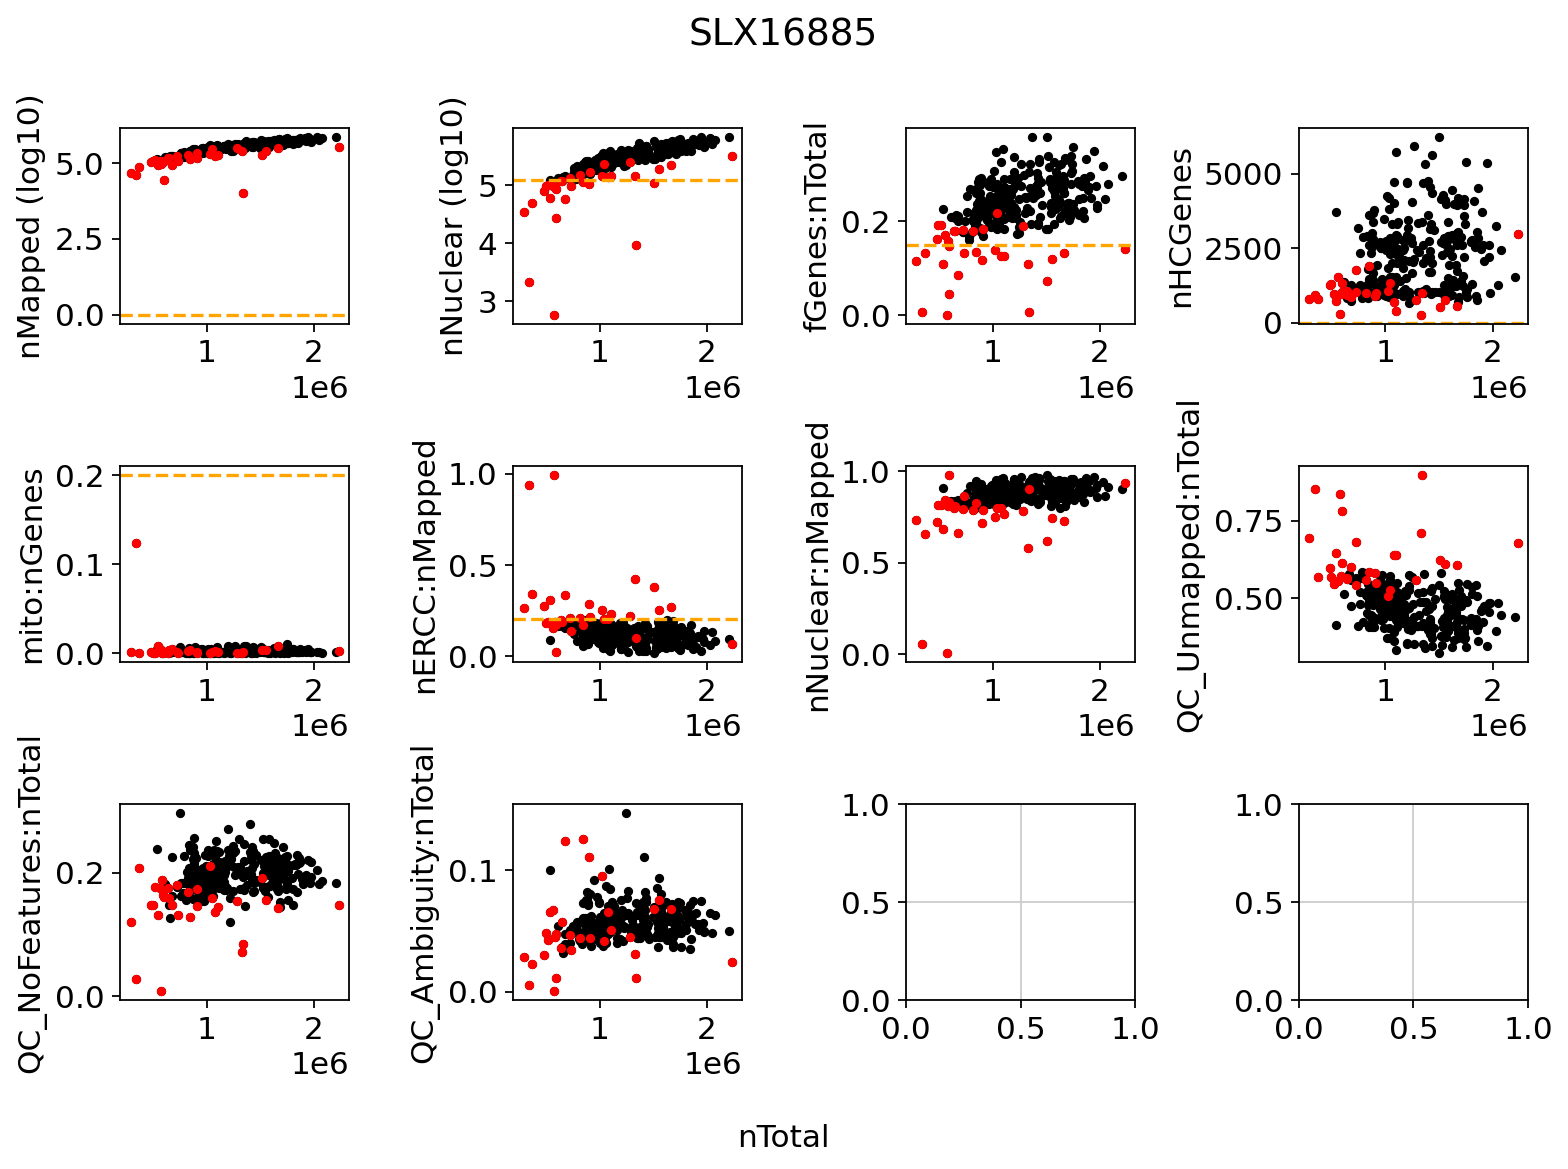

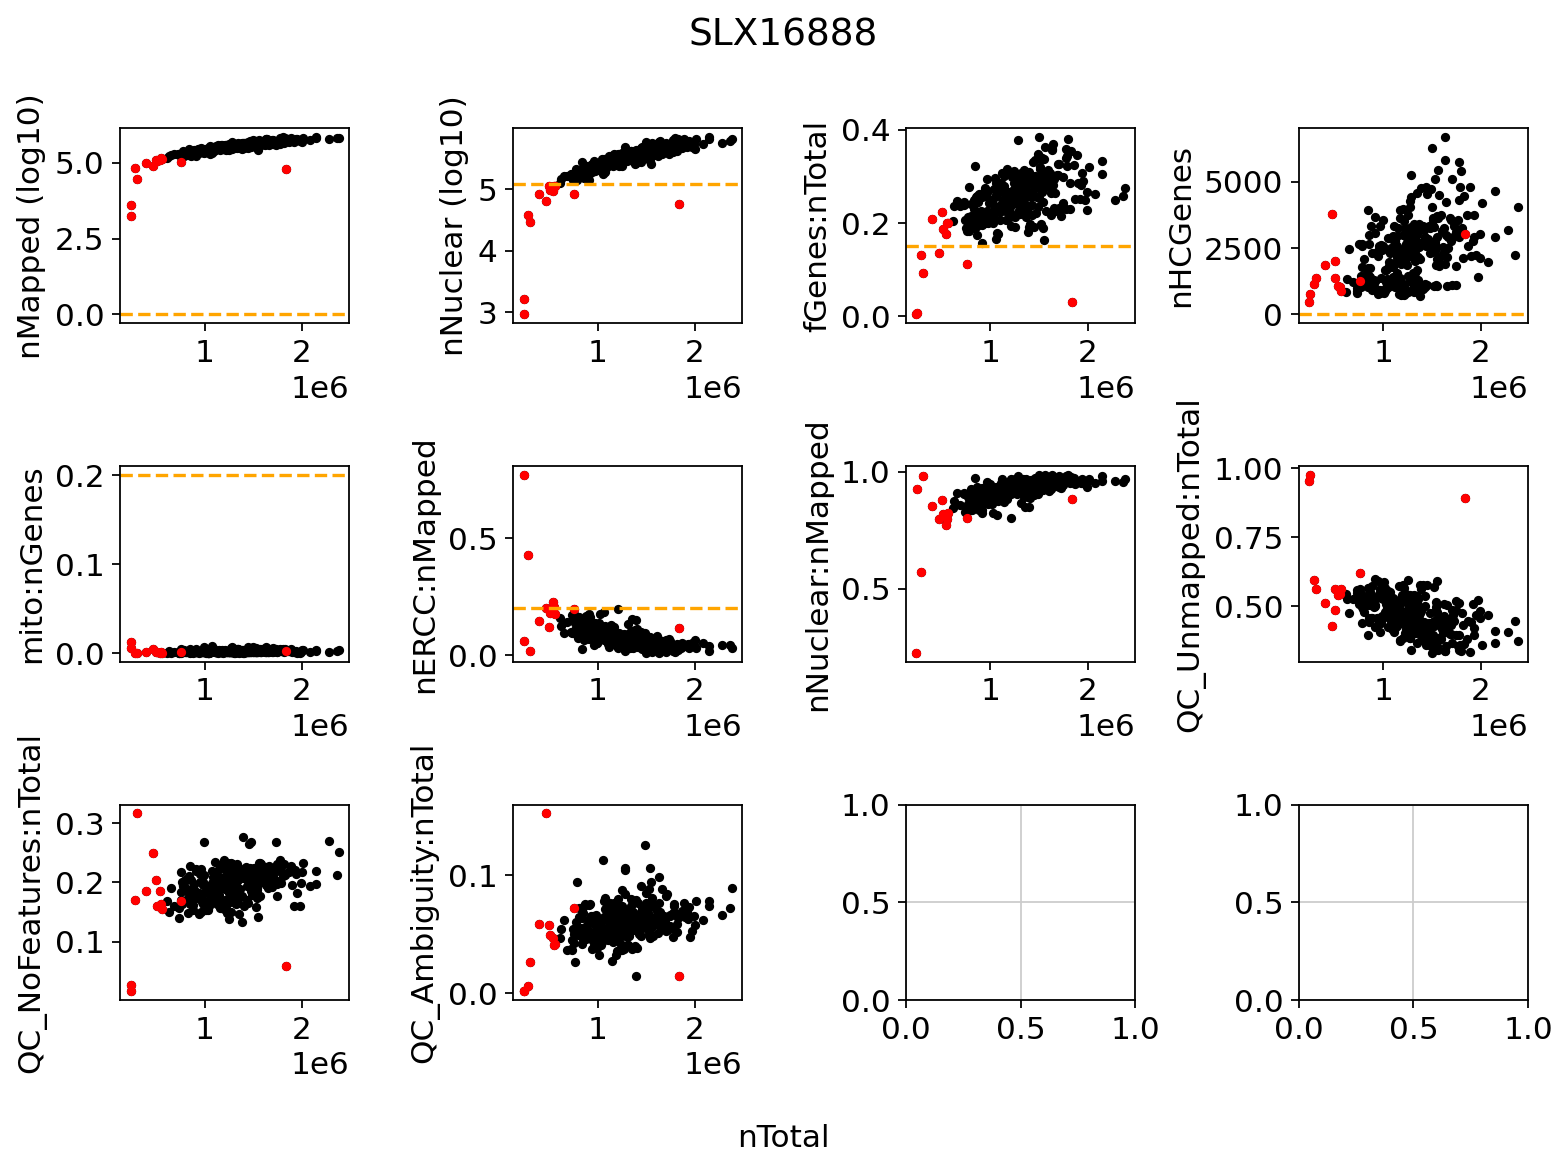

In [18]:
adata = []
for i in range(len(folder_list)):
    print(folder_list[i])
    adata_sub =  smqpp.read_in_files(Indir+folder_list[i], ftable_loc)
    adata_sub = smqpp.smartseq_qc(adata_sub,cutoff=cutoff[i], title=folder_list[i])
    adata.append(adata_sub)
    del adata_sub

In [16]:
# combine data
adata = anndata.AnnData.concatenate(adata[0], adata[1], adata[2], adata[3], adata[4], adata[5], adata[6], adata[7])
adata.obs_names = [x[:-2] for x in adata.obs_names]

In [17]:
# Remove SLX-14256.i706_i503 as md5sum check is wrong
adata = adata[adata.obs_names != 'SLX-14256.i706_i503',:].copy()

In [18]:
# add in meta
adata.obs = pd.concat([adata.obs, meta], axis=1, join='inner')

In [19]:
adata.write('./write/patel_smq2_raw.h5ad')

... storing 'Sequencing_identifier' as categorical
... storing 'Plate_number' as categorical
... storing 'Position_in_96_well_plate_sorted' as categorical
... storing 'Position_in_96_well_plate_RNAseq' as categorical
... storing 'FACs' as categorical
... storing 'Unique_sample_descriptor' as categorical
... storing 'Details' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'Owner' as categorical
... storing 'Species' as categorical
... storing 'Sequencing_index' as categorical
... storing 'Sequencing_facility_index' as categorical
... storing 'Condition' as categorical
... storing 'Gene Type' as categorical
... storing 'Chr' as categorical
... storing 'Start' as categorical
... storing 'End' as categorical
... storing 'Strand' as categorical


# Doublet removal

In [20]:
adata = sc.read('./write/patel_smq2_raw.h5ad')

In [21]:
# Then calculate the doublet score to remove potential doublets
import scrublet as scr
Batch_unique = np.unique(adata.obs['batch'])
db_scores = []
predicted_db = []
Cells = np.array([])
for i in Batch_unique:
    idx_sub = (adata.obs['batch']==i)
    Cells = np.append(Cells, adata[idx_sub,:].obs_names)
    scrub = scr.Scrublet(adata[idx_sub,:].X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    db_scores.append(doublet_scores)
    predicted_db.append(predicted_doublets)

Preprocessing...


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 14.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.9%
Elapsed time: 3.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 32.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.4%
Elapsed time: 0.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 37.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.4%
Elapsed time: 0.4 seconds
Preprocessing...


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 15.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.6%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 5.5%
Estimated detectable doublet fraction = 32.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 16.8%
Elapsed time: 0.3 seconds
Preprocessing...


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 9.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.7%
Elapsed time: 0.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 29.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.5%
Elapsed time: 0.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 12.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.5%
Elapsed time: 0.6 seconds


In [22]:
db_results = {'doublet_scores': np.concatenate(db_scores),
              'predicted_doublets': np.concatenate(predicted_db)
             }
db_results = pd.DataFrame.from_dict(db_results)
db_results.index = Cells
# save the doublet detection results due to randomness
db_results.to_csv('db_results.csv')

Batch0: Number of doublets =  1
Batch1: Number of doublets =  10
Batch2: Number of doublets =  18
Batch3: Number of doublets =  17
Batch4: Number of doublets =  28
Batch5: Number of doublets =  5
Batch6: Number of doublets =  23
Batch7: Number of doublets =  5


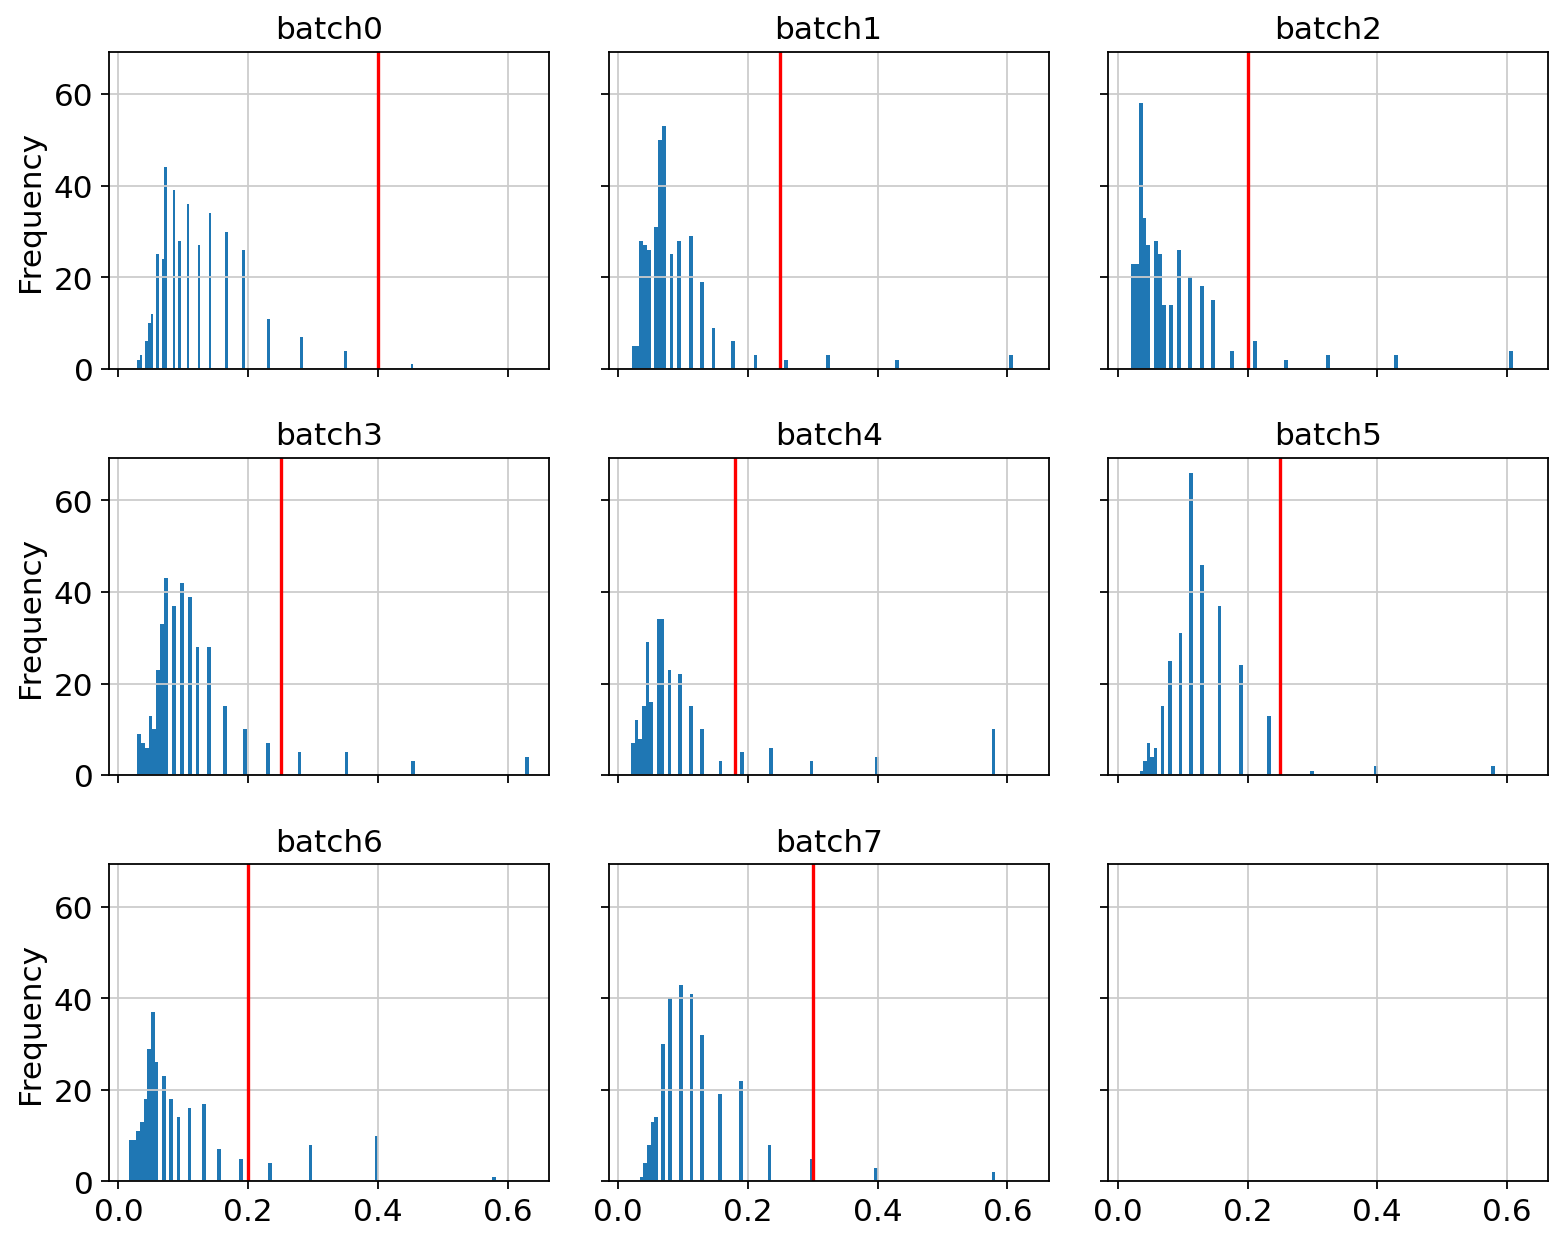

In [23]:
# otherwise just use the n_count for filtering
dcutoff = np.array([0.4,0.25,0.2,0.25,0.18,0.25,0.2,0.3])
db_pred = np.array([]) #save the new user defined dbs
ncol = 3
nrow = int(np.ceil(len(adata.obs['batch'].cat.categories)/ncol))
fig, ax = plt.subplots(nrow,ncol, figsize=(10,8), sharex=True, sharey=True)
for i in range(len(Batch_unique)):
    colidx = i%ncol
    rowidx = np.floor(i/ncol).astype(int)
    pd.DataFrame(db_scores[i]).plot.hist(bins=100, ax=ax[rowidx][colidx])
    #ax[rowidx][colidx].axvline(x=np.sort(db_scores[i])[::-1][np.sum(predicted_db[i])], color='b')
    # here use user defined cutoffs
    ax[rowidx][colidx].axvline(x=dcutoff[i], color='red')
    print('Batch'+str(i)+': Number of doublets = ', str(np.sum(db_scores[i] > dcutoff[i])))
    #print('Batch'+str(i)+': Number of doublets = ', str(np.sum(predicted_db[i])))
    ax[rowidx][colidx].get_legend().remove()
    ax[rowidx][colidx].set_title('batch'+np.unique(adata.obs['batch'])[i])
    db_pred = np.append(db_pred, db_scores[i] > dcutoff[i])
plt.tight_layout()  

In [24]:
# save the doublet score in adata
adata = adata[Cells,:].copy()
adata.obs['doublet_score'] = db_results['doublet_scores'].values

In [25]:
# doublets seen at the downstream analysis, remove cells with doublet score > 0.25
print(adata.shape)
print('Total # of doublets: '+str(int(np.sum(db_pred))))

(2535, 31053)
Total # of doublets: 107


In [26]:
# then remove doublet cells
adata = adata[db_pred==0,:].copy()

In [27]:
print(adata.shape)

(2428, 31053)


In [28]:
adata.write('./write/patel_smq2_raw.h5ad')

# Normalisation

In [29]:
adata = sc.read('./write/patel_smq2_raw.h5ad')

In [30]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 6913 genes that are detected in less than 1 cells


In [31]:
smqpp.normalise_data(adata)

Calculate SF for genes:
Filtered matrix shape: (2428, 13)
Number of valid means:13
Calculate SF for erccs:
Filtered matrix shape: (2428, 15)
Number of valid means:15


In [32]:
adata.raw = adata

In [33]:
adata.write('./write/patel_smq2_lognorm.h5ad')

# Downstream analysis the same as TenX
## Cell Cycle Assignment

In [34]:
# here start cell cycle assignment with log norm counts
adata = sc.read('./write/patel_smq2_lognorm.h5ad')

In [35]:
# Scaling must be done before scoring
sc.pp.scale(adata)

In [36]:
cell_cycle_genes = [x.strip().title() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [37]:
# reformat gene list
def reformat_GN(s):
    s = s[0].upper() + s[1:].lower()
    return(s)

In [38]:
cell_cycle_genes = [reformat_GN(x) for x in cell_cycle_genes]

In [39]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 94


In [40]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [41]:
adata.obs['phase'].value_counts().sort_index()

G1      682
G2M    1077
S       669
Name: phase, dtype: int64

In [42]:
# save cell cycle assignments
adata.obs[['phase', 'S_score', 'G2M_score']].to_csv('cell_cycle_results.txt')

# Look at sexual effect

In [113]:
df_sub = adata.obs[['mouseID', 'Cond1']].copy()
df_sub['Xist'] = adata.raw[:,'Xist'].X.flatten()
df_sub['Condition'] = df_sub['Cond1'].astype(str)+'_'+df_sub['mouseID'].astype(str)
df_sub['Condition'] = df_sub['Condition'].astype('category')
df_sub['Condition'] = df_sub['Condition'].cat.reorder_categories(np.sort(df_sub['Condition'].cat.categories))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

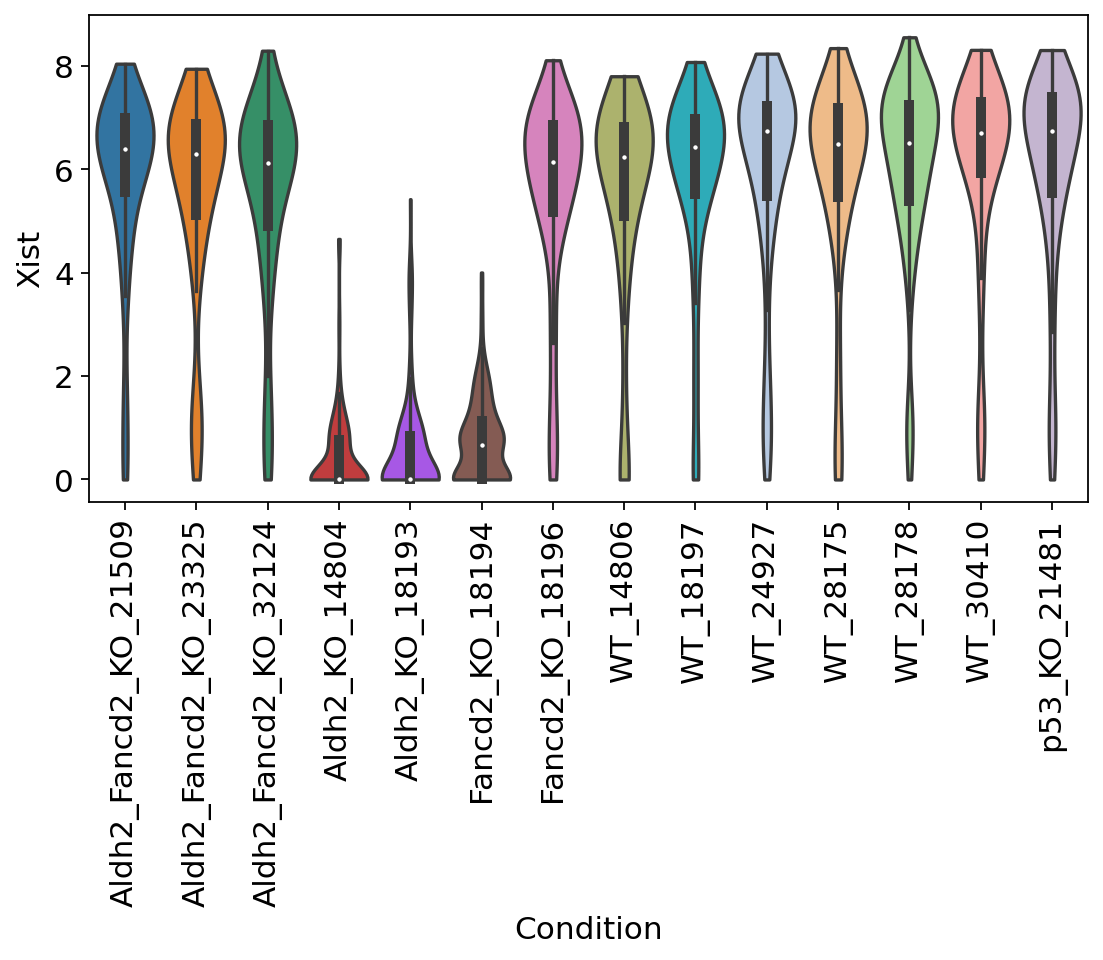

In [114]:
import seaborn as sns
plt.figure(figsize=(8,4))
ax = sns.violinplot(x='Condition', y='Xist', data=df_sub, scale='width', cut=0)
ax.grid(False)
plt.xticks(rotation=90)

In [4]:
# Save the sex obs
sex = {'21509':'F',
      '23325': 'F',
      '32124': 'F',
      '14804': 'M',
      '18193': 'M',
      '18194': 'M',
      '18196': 'F',
      '14806': 'F',
      '18197': 'F',
      '24927': 'F',
      '28175': 'F',
      '28178': 'F',
      '30410': 'F',
      '21481': 'F'}
adata.obs['Sex'] = [sex[x] for x in adata.obs['mouseID']]

Sex will be one of the confounding factors.

# Select Highly Variable Genes

In [43]:
# start from log norm counts again
adata = sc.read('./write/patel_smq2_lognorm.h5ad')

In [44]:
# save the cell cycle results
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [45]:
smqpp.tech_var(adata, useERCC=True) 

32
Length of HVGs: 9441


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:282: RuntimeWarning: invalid value encountered in true_divide
  cv2s = (sStd/sMean)**2
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:287: RuntimeWarning: invalid value encountered in greater
  meanForFit = np.quantile(sMean[cv2s>cvThresh], quant)
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


In [46]:
smqpp.plot_tech_var(adata)

In [47]:
adata.shape

(2428, 24140)

In [48]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [49]:
adata.shape

(2428, 9441)

In [50]:
# scale for pca
sc.pp.scale(adata)

# Visualization

computing PCA with n_comps = 50
    finished (0:00:03)


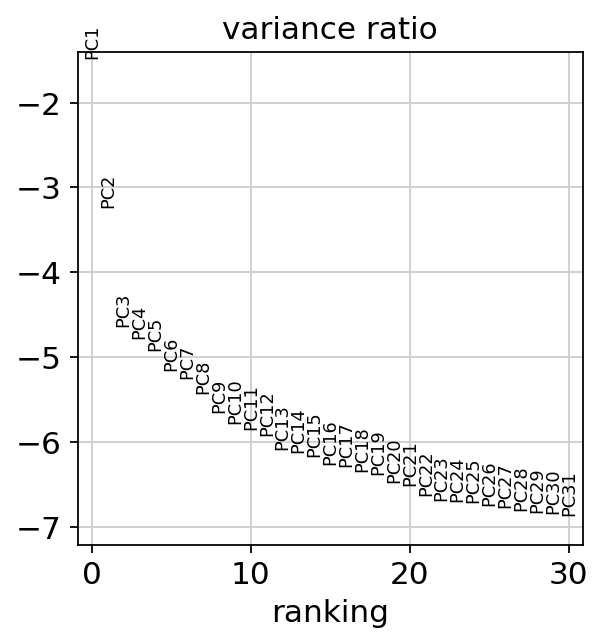

In [51]:
# Try different visualisations
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [52]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:16)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:16)


In [24]:
keys2plot = ['batch', 'n_counts', 'n_genes', 'doublet_score', 'phase',  'Cell_type_general', 'Sex', 'Cond1']

In [22]:
# reorder Cond1
adata.obs['Cond1'] = adata.obs['Cond1'].astype('category')
adata.obs['Cond1'] = adata.obs['Cond1'].cat.reorder_categories(['WT', 'Aldh2_KO', 'Fancd2_KO', 'p53_KO', 'Aldh2_Fancd2_KO'])

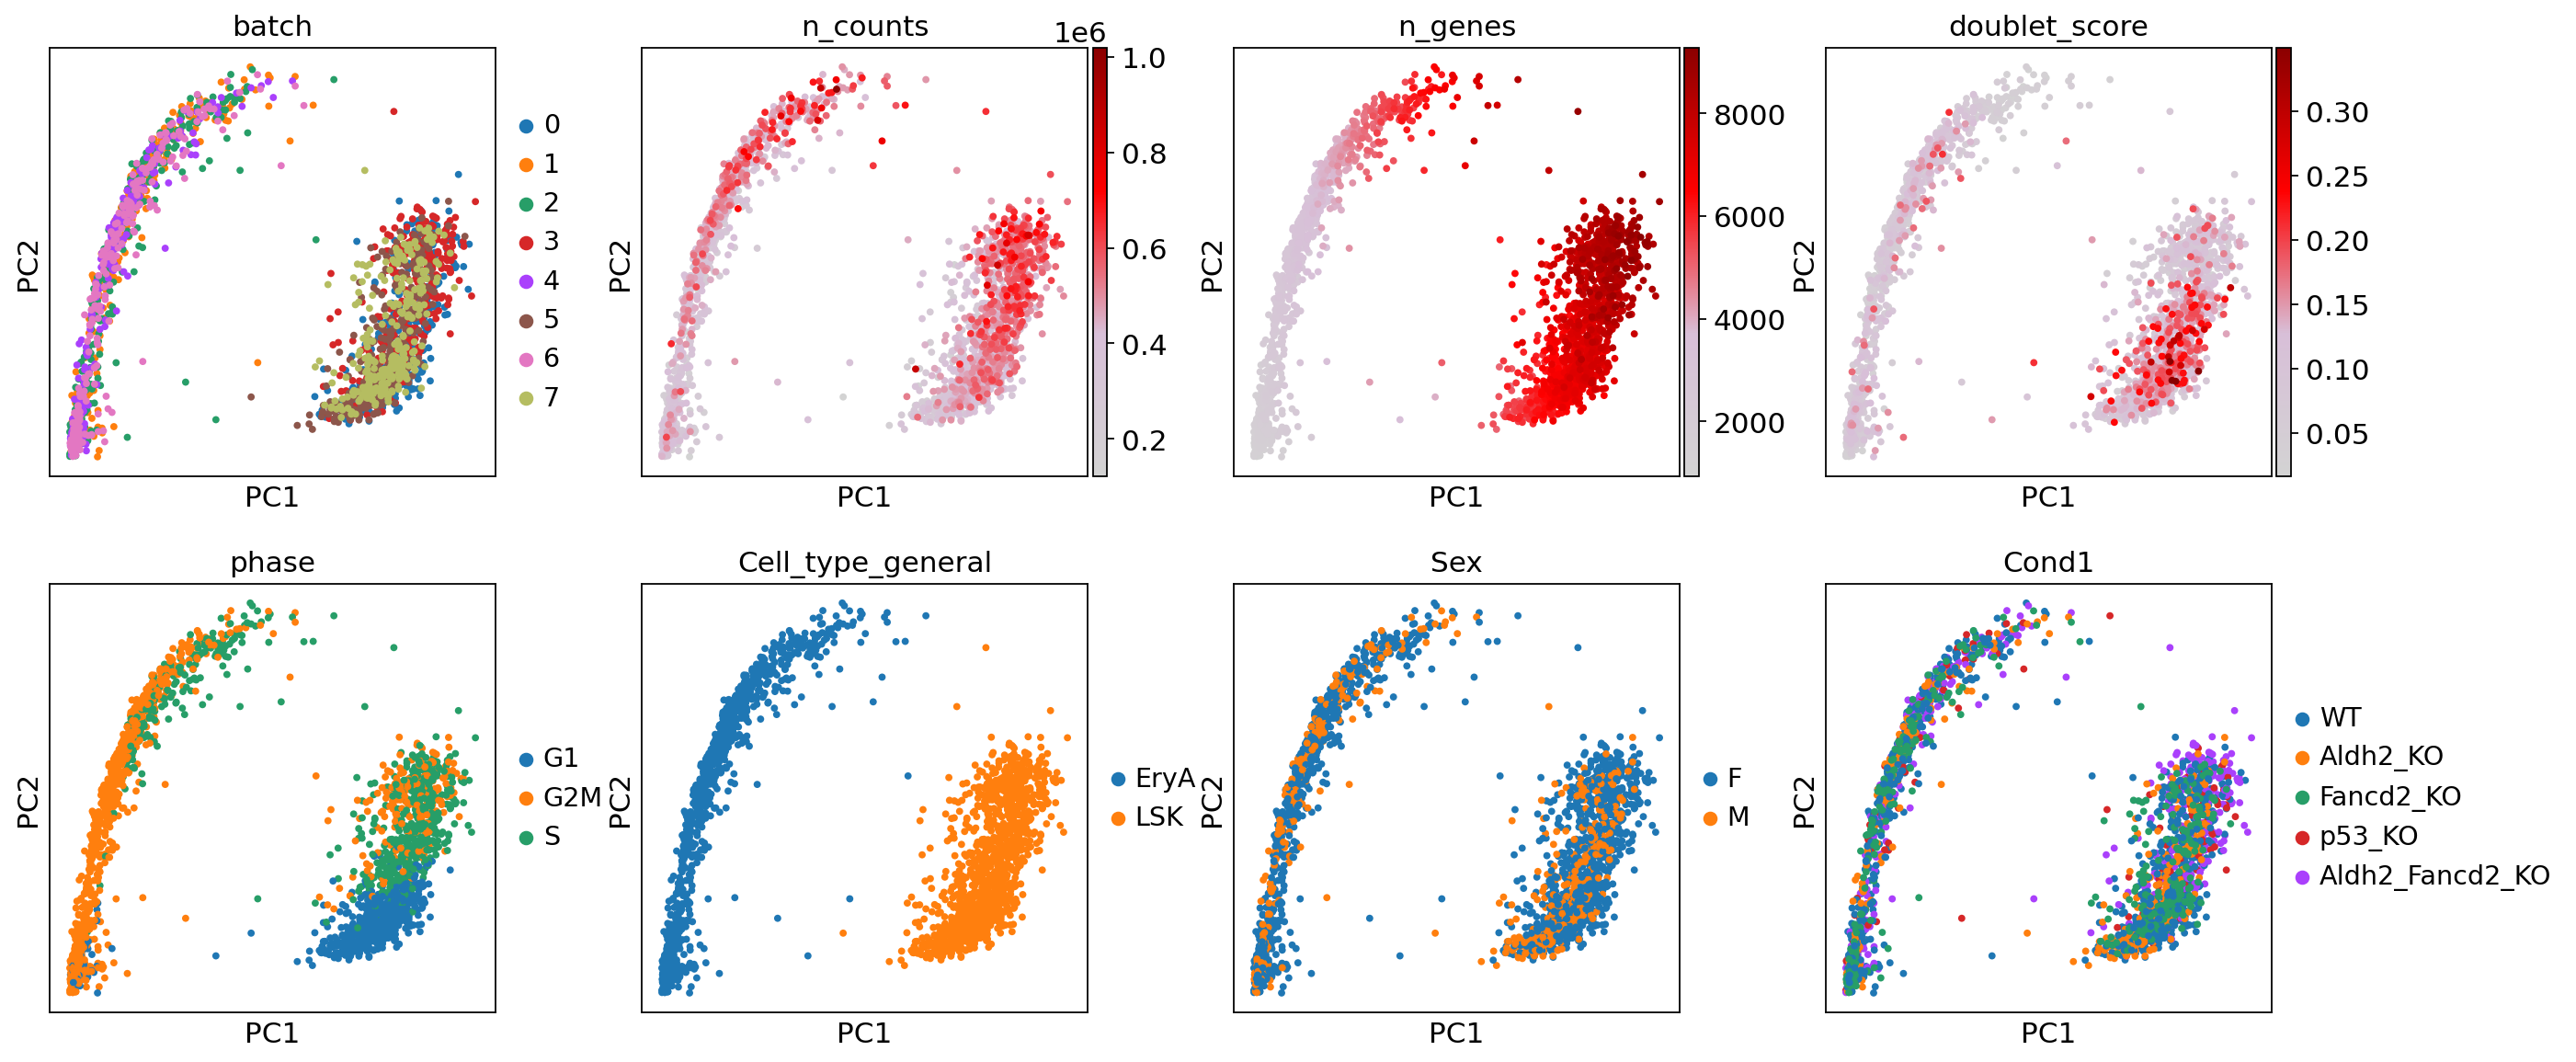

In [25]:
sc.pl.pca_scatter(adata, color=keys2plot, color_map=cmap)

In [26]:
sc.pl.umap(adata, color=keys2plot, color_map=cmap)

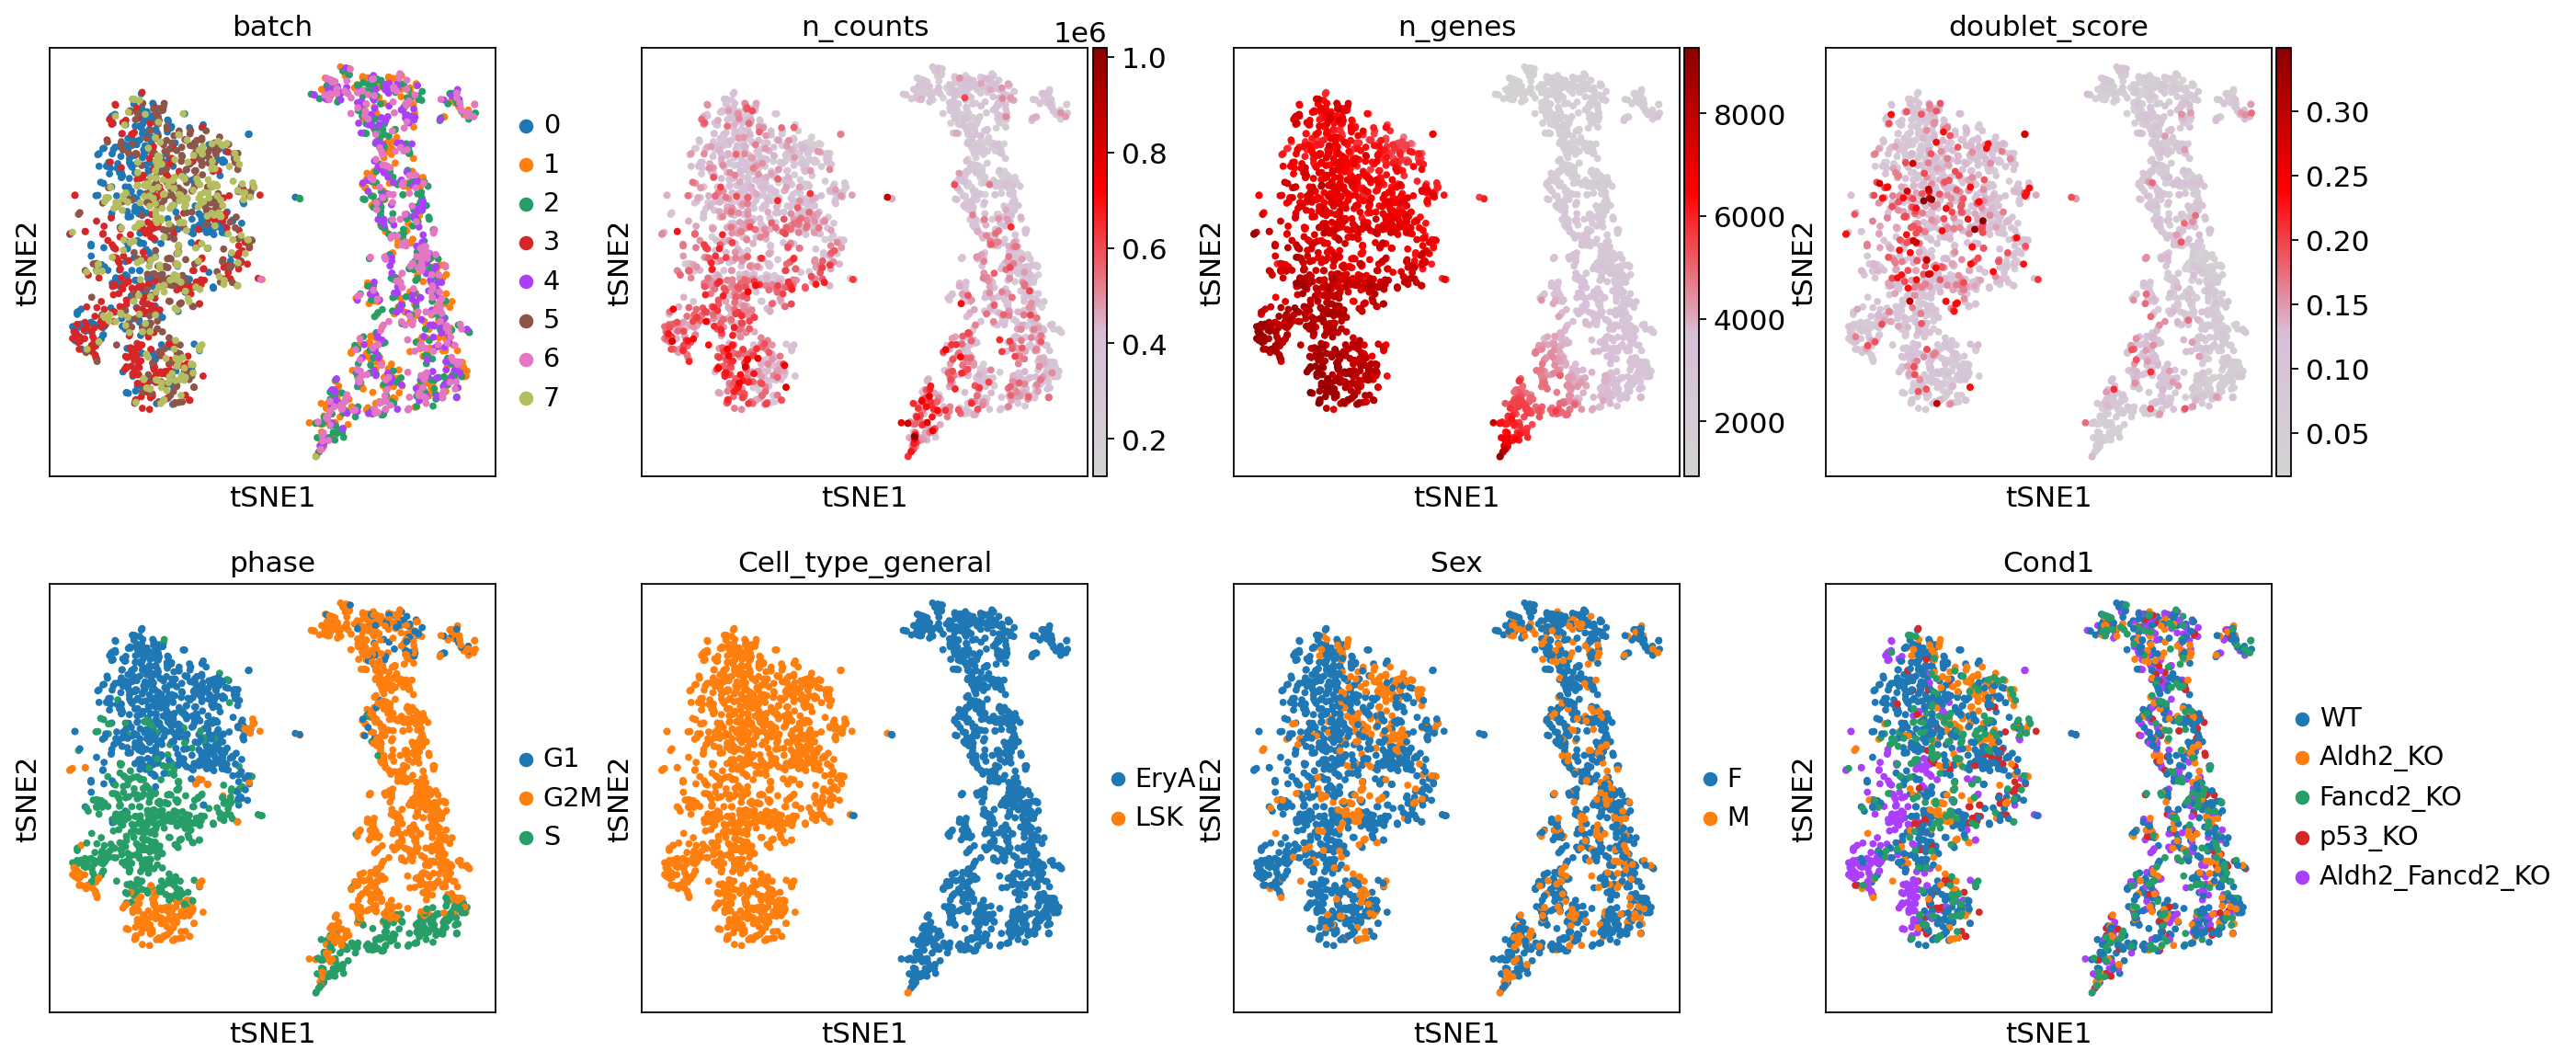

In [27]:
sc.pl.tsne(adata, color=keys2plot, color_map=cmap)

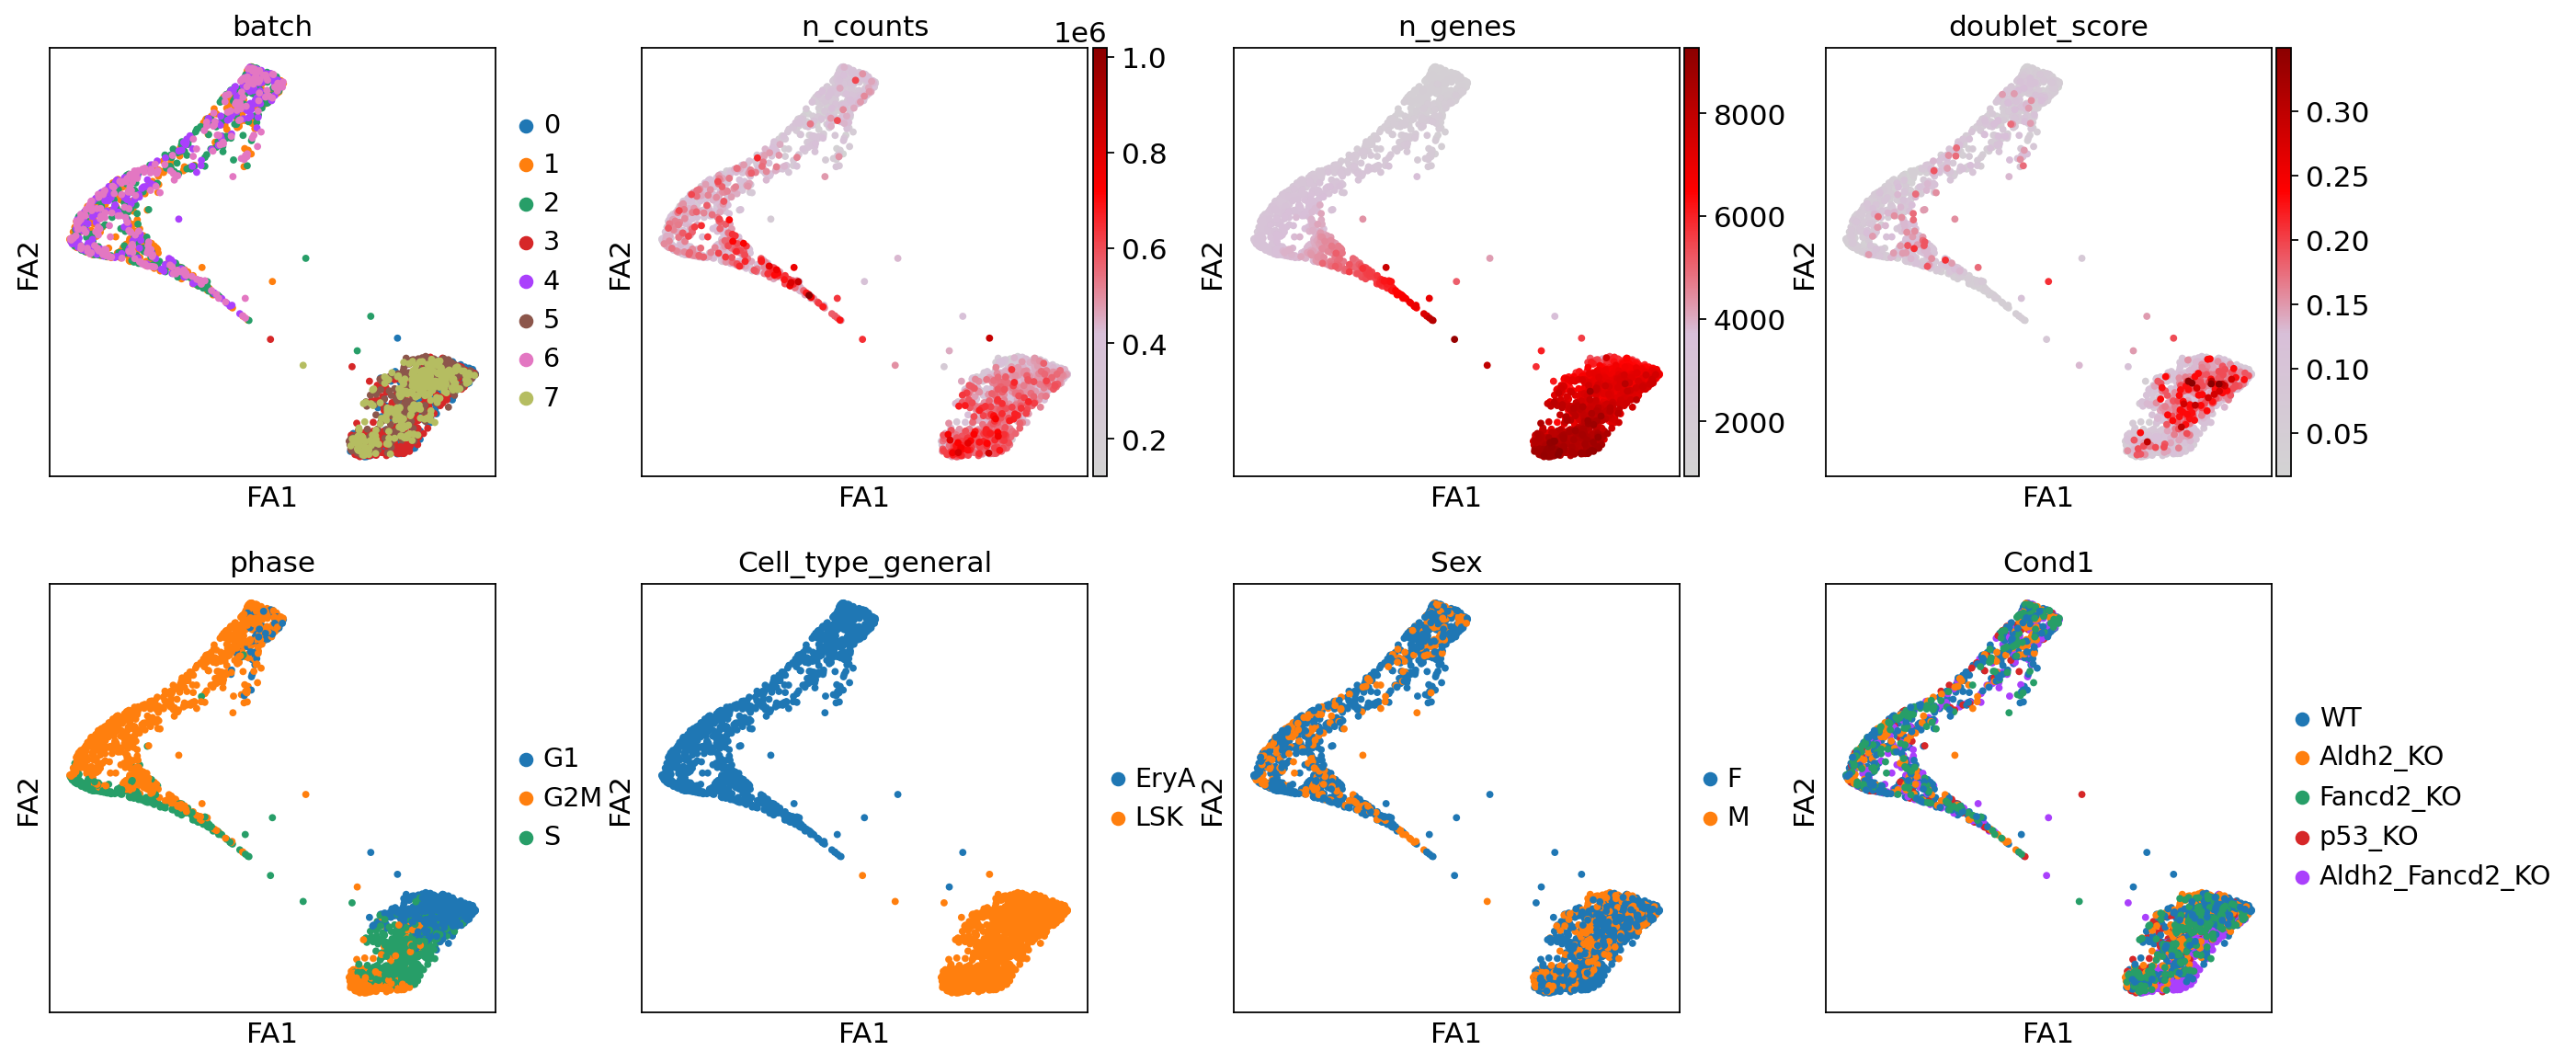

In [28]:
sc.pl.draw_graph(adata, color=keys2plot, color_map=cmap)

In [29]:
adata.write('./write/patel_smq2_processed.h5ad')

# Split data 

In [3]:
adata = sc.read('./write/patel_smq2_processed.h5ad')

In [30]:
adata_raw = sc.read('./write/patel_smq2_raw.h5ad')

In [31]:
adata_raw.obs = adata.obs

In [32]:
adata_LSK = adata_raw[adata_raw.obs['Cell_type_general'] == 'LSK', :].copy()
adata_EryA = adata_raw[adata_raw.obs['Cell_type_general'] == 'EryA', :].copy()

In [33]:
adata_LSK.write('./write/patel_smq2_LSK_raw.h5ad')
adata_EryA.write('./write/patel_smq2_EryA_raw.h5ad')